# Initial Data Exploration

Aight, let's have a look at the data we are working with!

This notebook will mostly be about exploring the data, maybe discovering some connections (or not).

Maybe I will even use the dataset in a first, very clumsy model. Let's see.

This is all just early stages, I will probably backpedal a bit in the next notebook and continue a bit more organized.
But for now, some fun with data:

## loading data

The file I am loading is just a json dump from the API that recorded the measurements from the sensor.

In [13]:
import pandas as pd
with open("../data/measurements.json") as file:
    data = pd.read_json(file)

In [14]:
data.head()

,humidity,measuredAt,temperature
0,34.2,2018-02-20T19:00:08.145411Z,17.1
1,33.3,2018-02-20T18:00:09.190775Z,16.8
2,32.5,2018-02-20T17:00:10.197395Z,17.9
3,34.8,2018-02-20T16:00:08.208562Z,17.7
4,35.9,2018-02-20T15:00:08.232641Z,17.9


## Some initial insights

Aight, so the datapoints are recorded every hour.

The info() method is especially useful to get a feel for the shape of the data. There are 6138 instances in the dataset, which is fairly small, but a doable start.

The number of non-null values for each column is very interesting - I got lucky, there are no values missing in any columns, otherwise I would've needed to take care of that (the number of non-null values for each column is the same as the number of instances in the dataset).

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6138 entries, 0 to 6137
Data columns (total 3 columns):
humidity       6138 non-null float64
measuredAt     6138 non-null object
temperature    6138 non-null float64
dtypes: float64(2), object(1)
memory usage: 191.8+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116748d30>,
      dtype=object)

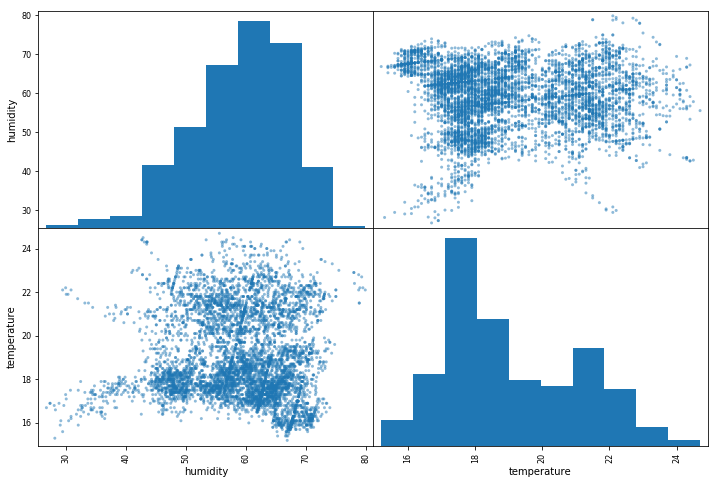

In [16]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, figsize=(12, 8))

The correlation coefficients range from -1 to 1. When there is a strong positive correlation (close to 1) it means that a value tends to go up when the other one goes up.

When there is a strong negative correlation (close to -1) it means that a value tends to go down when the correlated value goes down.

It seems there is a slight negative correlation between temperature and humidity (when one of them goes down, the other tends to go down a bit too).

This will become much more interesting once we add some more features.

In [17]:
data.corr()

,humidity,temperature
humidity,1.000000,-0.020763
temperature,-0.020763,1.000000


I will add a few features, hour and month, by extracting them from the timestamp. The strongest correlation we can find is between month and humidity. The later in the year we are, the higher the humidity tends to go up. Hmm...

In [18]:
data['hour'] = pd.DatetimeIndex(data['measuredAt']).hour
data['month'] = pd.DatetimeIndex(data['measuredAt']).month
data.corr()

,humidity,temperature,hour,month
humidity,1.000000,-0.020763,-0.030269,0.597713
temperature,-0.020763,1.000000,0.077384,-0.140751
hour,-0.030269,0.077384,1.000000,0.000898
month,0.597713,-0.140751,0.000898,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11deaffd0>,
      dtype=object)

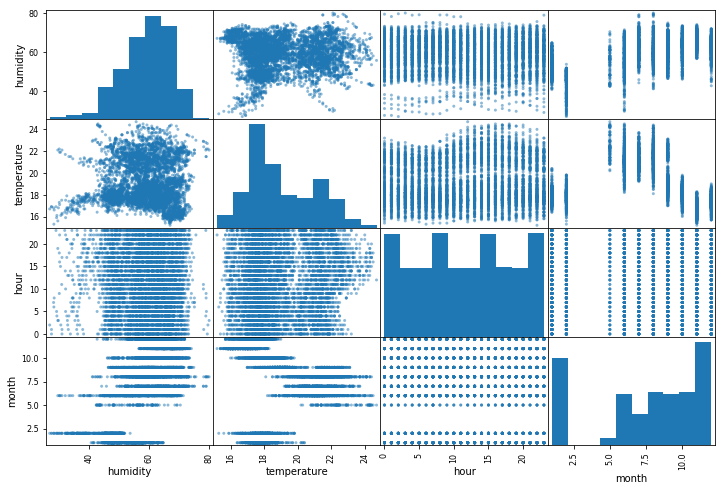

In [19]:
scatter_matrix(data, figsize=(12, 8))

Ok, plotting time! This is probably the most valuable overview we can get initially.

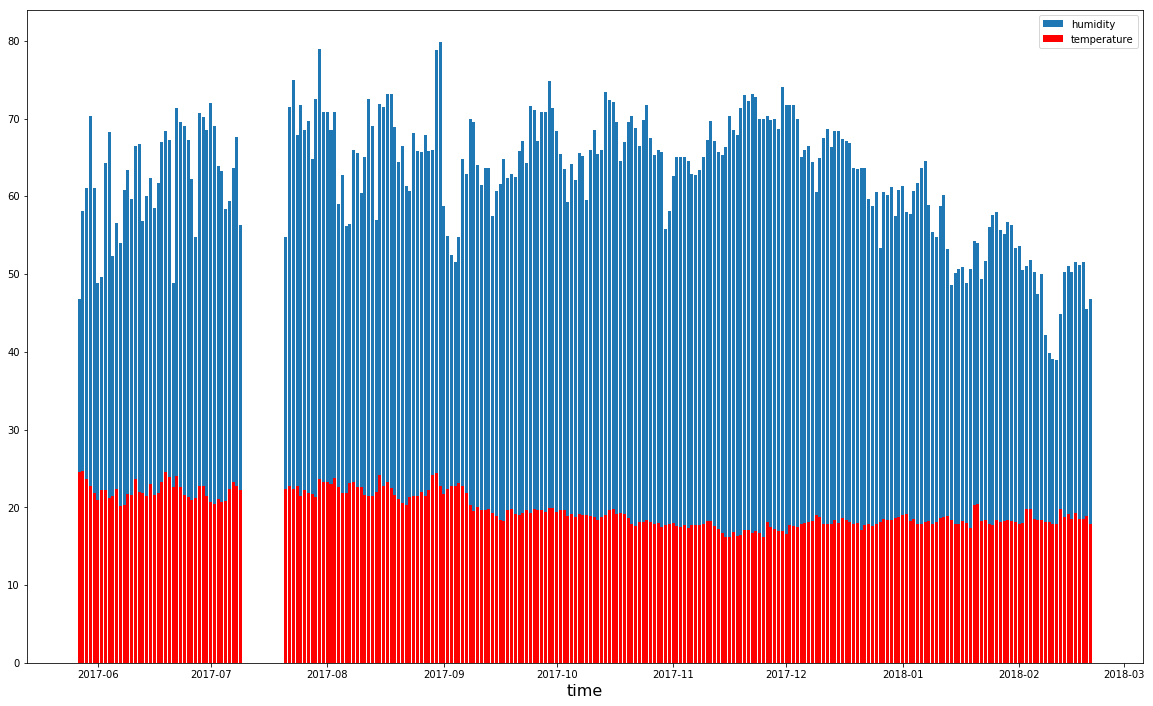

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

# creating timestamps for the x axis
dates = [dt.datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.%fZ').date() for d in data.measuredAt]
plt.figure(figsize=(20,12))
plt.xlabel("time", fontsize=16)
plt.bar(dates, data.humidity, label="humidity")

# humidity and temperature are obviously not on the same scale here
plt.bar(dates, data.temperature, color="red", label="temperature")
plt.legend()
plt.show()

Oh right, the sensor was disconnected for a bit last year - the missing data in the time series is something I need to deal with later.

![suspicious drop](img/data_drop.png)

important side note: If you value peace and harmony at home, you should not gleefully start singing to your girlfriend:

"I found the cause, it is you, it is YOU! the data doesn't lie, it doesn't lie, doesn't lie".

Especially if she has a PhD in this stuff and can easily show you the folly of your premature assumptions.

The major folly in this case being: I was trying to come up with too detailed conclusions on perceived patterns I detected in the dataset.

Your brain(my brain too I would hope) is a fantastic pattern detector and very prone to _overfitting_.

Which means that whatever solution we would create, it might work great for the data we are looking at, but would likely be very bad at generalizing. There is more to the story and I will return to it at a later point, when we measure the performance of the algorithm.

To avoid overfitting and to properly measure the performance we will split the dataset into a training set and a test set. The training set will be used to train the regressor and the test set will be used to evaluate the performance. Do not snoop into the test set! Otherwise you might accidentally start overfitting on the test set too.

## EXTRA: A first, clumsy model

Ok, so, this is just a silly late night experiment, feel free to skip it.

For now, I will ignore that the dataset is a time series. In time series data the sequence is important and adds another complexity to the whole thing.

What I will do for now, is just use the temperature, hour and month as features to predict the humidity. Same datapoint.

I will not go into much detail for now, but don't worry, in the next notebook of this series we will do this properly and (hopefully) well explained.

Later on, I will use previous datapoints to predict future datapoints, but for now, a silly, first model.

In [21]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

as mentioned before, we will need two datasets, one to train the model, the other to test and measure it on.

In [22]:
feature_attributes = ['temperature', 'hour', 'month']
label_attributes = ['humidity']
X_train, y_train = train_set[feature_attributes], train_set[label_attributes]
X_test, y_test = test_set[feature_attributes], test_set[label_attributes]

The model itself is a very simple linear regression model

In [23]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

/Users/oem/.pyenv/versions/3.6.3/envs/habitat/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

after we fit the model to the training set, we can measure its performance on the test set.

In [24]:
from sklearn.metrics import mean_squared_error
predictions = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


6.536509325330448

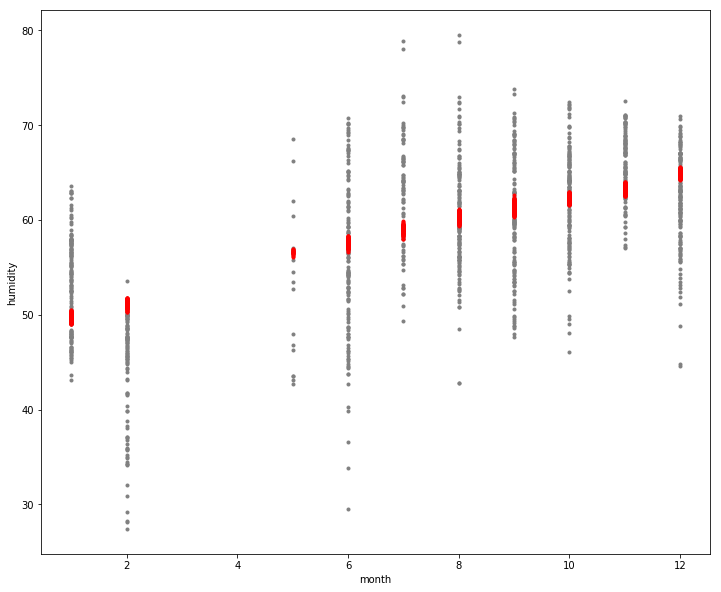

In [25]:
plt.figure(figsize=(12,10))
plt.plot(X_test['month'], y_test, '.', color='gray')
plt.plot(X_test['month'], predictions, '.', color='r')
plt.xlabel('month')
plt.ylabel('humidity')
plt.show()

Now, as I said before, this is a silly model and not very usable. The next notebook will also train a linear regression model, but treating the data as the time series that it is.

We also haven't done any scaling of the data or some of the other necessary steps.